# Sommaire

>[Sommaire](#scrollTo=OXXSgYy9BBec)

>[Imports et paramètres généraux](#scrollTo=zC7YhIrj59gy)

>[Création des modèles à entraîner](#scrollTo=gZFVwEW96EaG)

>[Fonctions d'affichages et d'enregistrements](#scrollTo=m_Wx43PK6pdE)

>[Entraînement](#scrollTo=5CAxdPTM6wkq)

>[Téléchargements](#scrollTo=4QJiqfKLBU_W)



# Imports et paramètres généraux

Imports des librairies principales et réglage des paramètres d'aléa

In [2]:
!pip install tqdm

# gestions relatives aux fichiers de manière générale
import os

# choix de tensorflow comme backend de Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# opérations matricielles
import numpy as np

from tqdm import tqdm

# affichages
import matplotlib.pyplot as plt

# les différentes parties utilisées de Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, Adagrad
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# on fixe le seed du random de numpy pour avoir des résultats reproductibles
np.random.seed(1000)

# On choisit la taille du vecteur aléatoire d'entrée du GAN
# 10 marche bien pour MNIST d'après la littérature
# 100 permet une adaptation plus simple à d'autres GANs
randomDim = 100

    100% |████████████████████████████████| 51kB 3.6MB/s 


Using TensorFlow backend.


Chargement du dataset

In [3]:
# Chargement directement depuis Keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalisation des données
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# Mise en forme des données d'entraînement
X_train = X_train.reshape(60000, 784)

11501568/11490434 [==============================] - 3s 0us/step


# Création des modèles à entraîner

Configuration du Générateur

In [0]:
# Architecture trouvée dans la littérature, marche bien pour MNIST
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128,7,7)))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=Adagrad(lr=0.001, epsilon=None, decay=0.0))

Configuration du Discriminateur

In [0]:
# Architecture trouvée dans la littérature, marche bien pour MNIST
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=Adagrad(lr=0.001, epsilon=None, decay=0.0))

Configuration du GAN comme assemblage du Générateur et du Discriminateur

In [0]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Fonctions d'affichages et d'enregistrements

In [0]:
# Affichage de la fonction de coût
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Affichage d'une mosaïque d'images générées par le Générateur
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [0]:
# sauvegarde des réseaux de neurones
def saveModels(epoch):
    generator.save('gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('gan_discriminator_epoch_%d.h5' % epoch)

# Entraînement

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 100
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


 20%|██        | 95/468 [00:09<00:38,  9.58it/s]/usr/local/lib/python2.7/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
  0%|          | 1/468 [00:00<00:49,  9.39it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:36, 12.66it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:35, 12.97it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:35, 13.00it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:37, 12.46it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:35, 12.99it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:37, 12.52it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:37, 12.40it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:37, 12.43it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:35, 13.12it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:35, 12.95it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:36, 12.87it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:36, 12.61it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:37, 12.55it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:35, 13.00it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:37, 12.58it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:36, 12.92it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:35, 13.15it/s]

--------------- Epoch 20 ---------------


  0%|          | 1/468 [00:00<00:49,  9.48it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:36, 12.75it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:34, 13.42it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:35, 13.13it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:36, 12.82it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:37, 12.45it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:34, 13.38it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:35, 13.18it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:35, 13.02it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:36, 12.90it/s]

--------------- Epoch 30 ---------------


  0%|          | 2/468 [00:00<00:36, 12.90it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:36, 12.69it/s]

--------------- Epoch 32 ---------------


  0%|          | 2/468 [00:00<00:36, 12.75it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:36, 12.71it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:37, 12.55it/s]

--------------- Epoch 35 ---------------


  0%|          | 2/468 [00:00<00:36, 12.68it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:35, 13.23it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:36, 12.89it/s]

--------------- Epoch 39 ---------------


  0%|          | 2/468 [00:00<00:37, 12.32it/s]

--------------- Epoch 40 ---------------


  0%|          | 1/468 [00:00<00:49,  9.34it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 42 ---------------


  0%|          | 2/468 [00:00<00:35, 12.97it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:36, 12.60it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:37, 12.34it/s]

--------------- Epoch 45 ---------------


  0%|          | 2/468 [00:00<00:35, 13.09it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:36, 12.65it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:35, 13.11it/s]

--------------- Epoch 48 ---------------


  0%|          | 2/468 [00:00<00:35, 13.09it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:36, 12.68it/s]

--------------- Epoch 50 ---------------


  0%|          | 2/468 [00:00<00:35, 13.05it/s]

--------------- Epoch 51 ---------------


  0%|          | 2/468 [00:00<00:36, 12.86it/s]

--------------- Epoch 52 ---------------


  0%|          | 2/468 [00:00<00:37, 12.50it/s]

--------------- Epoch 53 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 54 ---------------


  0%|          | 2/468 [00:00<00:36, 12.90it/s]

--------------- Epoch 55 ---------------


  0%|          | 2/468 [00:00<00:36, 12.68it/s]

--------------- Epoch 56 ---------------


  0%|          | 2/468 [00:00<00:37, 12.57it/s]

--------------- Epoch 57 ---------------


  0%|          | 2/468 [00:00<00:36, 12.65it/s]

--------------- Epoch 58 ---------------


  0%|          | 2/468 [00:00<00:35, 13.06it/s]

--------------- Epoch 59 ---------------


  0%|          | 2/468 [00:00<00:36, 12.71it/s]

--------------- Epoch 60 ---------------


  0%|          | 1/468 [00:00<00:47,  9.91it/s]

--------------- Epoch 61 ---------------


  0%|          | 2/468 [00:00<00:37, 12.44it/s]

--------------- Epoch 62 ---------------


  0%|          | 2/468 [00:00<00:37, 12.41it/s]

--------------- Epoch 63 ---------------


  0%|          | 2/468 [00:00<00:36, 12.93it/s]

--------------- Epoch 64 ---------------


  0%|          | 2/468 [00:00<00:36, 12.71it/s]

--------------- Epoch 65 ---------------


  0%|          | 2/468 [00:00<00:36, 12.78it/s]

--------------- Epoch 66 ---------------


  0%|          | 2/468 [00:00<00:37, 12.56it/s]

--------------- Epoch 67 ---------------


  0%|          | 2/468 [00:00<00:36, 12.61it/s]

--------------- Epoch 68 ---------------


  0%|          | 2/468 [00:00<00:35, 12.97it/s]

--------------- Epoch 69 ---------------


  0%|          | 2/468 [00:00<00:36, 12.88it/s]

--------------- Epoch 70 ---------------


  0%|          | 2/468 [00:00<00:37, 12.54it/s]

--------------- Epoch 71 ---------------


  0%|          | 2/468 [00:00<00:35, 13.13it/s]

--------------- Epoch 72 ---------------


  0%|          | 2/468 [00:00<00:35, 13.17it/s]

--------------- Epoch 73 ---------------


  0%|          | 2/468 [00:00<00:37, 12.52it/s]

--------------- Epoch 74 ---------------


  0%|          | 2/468 [00:00<00:35, 13.10it/s]

--------------- Epoch 75 ---------------


  0%|          | 2/468 [00:00<00:36, 12.91it/s]

--------------- Epoch 76 ---------------


  0%|          | 2/468 [00:00<00:35, 12.95it/s]

--------------- Epoch 77 ---------------


  0%|          | 2/468 [00:00<00:36, 12.65it/s]

--------------- Epoch 78 ---------------


  0%|          | 2/468 [00:00<00:36, 12.62it/s]

--------------- Epoch 79 ---------------


  0%|          | 2/468 [00:00<00:36, 12.79it/s]

--------------- Epoch 80 ---------------


  0%|          | 1/468 [00:00<00:49,  9.34it/s]

--------------- Epoch 81 ---------------


  0%|          | 2/468 [00:00<00:36, 12.61it/s]

--------------- Epoch 82 ---------------


  0%|          | 2/468 [00:00<00:35, 13.15it/s]

--------------- Epoch 83 ---------------


  0%|          | 2/468 [00:00<00:34, 13.40it/s]

--------------- Epoch 84 ---------------


  0%|          | 2/468 [00:00<00:35, 13.05it/s]

--------------- Epoch 85 ---------------


  0%|          | 2/468 [00:00<00:37, 12.48it/s]

--------------- Epoch 86 ---------------


  0%|          | 2/468 [00:00<00:35, 12.98it/s]

--------------- Epoch 87 ---------------


  0%|          | 2/468 [00:00<00:36, 12.87it/s]

--------------- Epoch 88 ---------------


  0%|          | 2/468 [00:00<00:35, 12.98it/s]

--------------- Epoch 89 ---------------


  0%|          | 2/468 [00:00<00:36, 12.67it/s]

--------------- Epoch 90 ---------------


  0%|          | 2/468 [00:00<00:35, 13.07it/s]

--------------- Epoch 91 ---------------


  0%|          | 2/468 [00:00<00:35, 13.02it/s]

--------------- Epoch 92 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 93 ---------------


  0%|          | 2/468 [00:00<00:36, 12.93it/s]

--------------- Epoch 94 ---------------


  0%|          | 2/468 [00:00<00:36, 12.74it/s]

--------------- Epoch 95 ---------------


  0%|          | 2/468 [00:00<00:35, 13.18it/s]

--------------- Epoch 96 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 97 ---------------


  0%|          | 2/468 [00:00<00:35, 12.98it/s]

--------------- Epoch 98 ---------------


  0%|          | 2/468 [00:00<00:36, 12.90it/s]

--------------- Epoch 99 ---------------


  0%|          | 2/468 [00:00<00:38, 12.11it/s]

--------------- Epoch 100 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.76it/s]


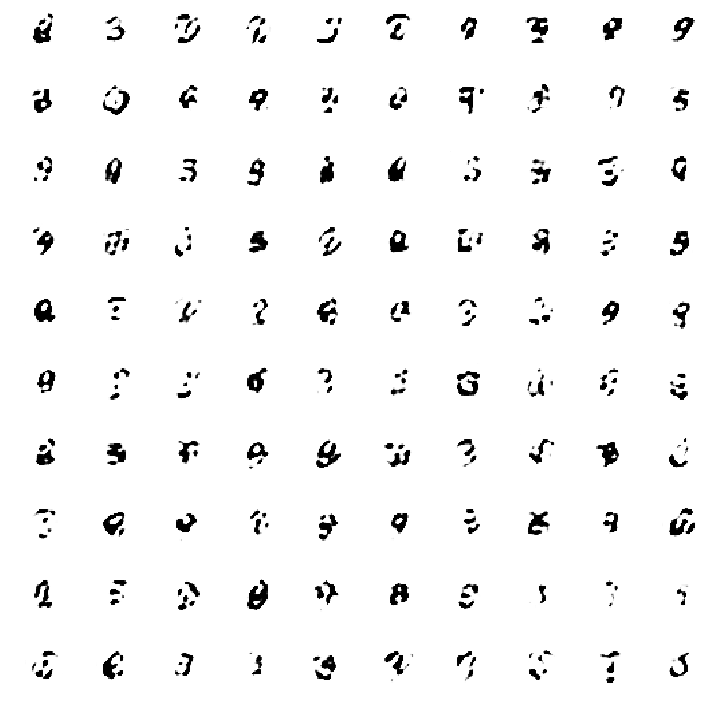

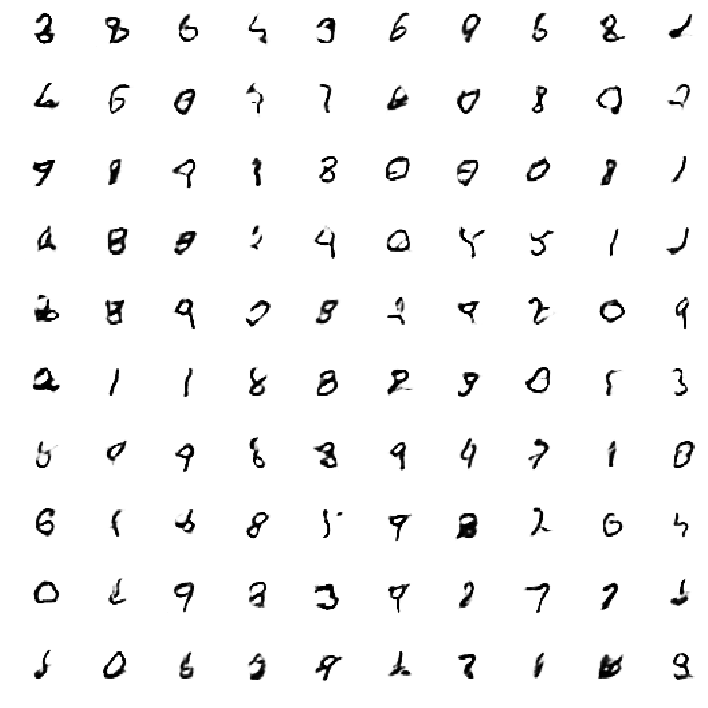

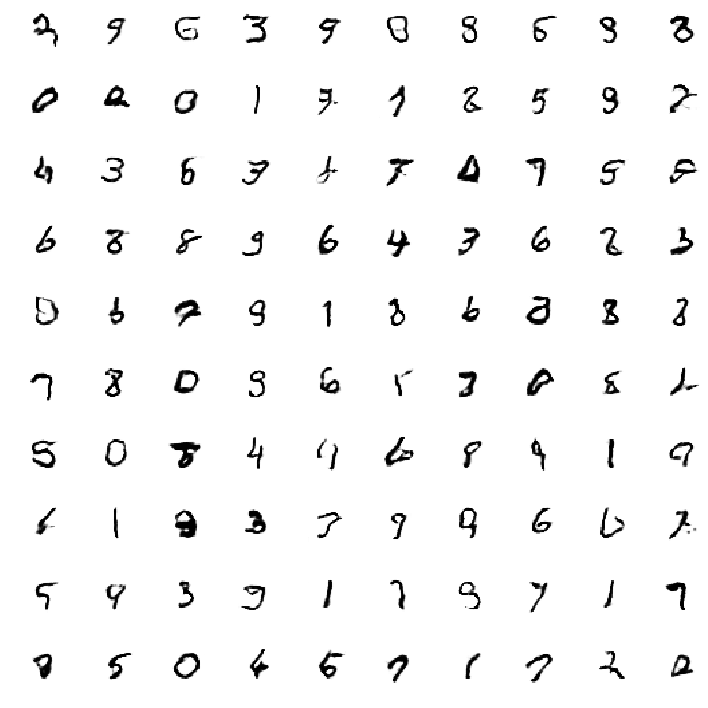

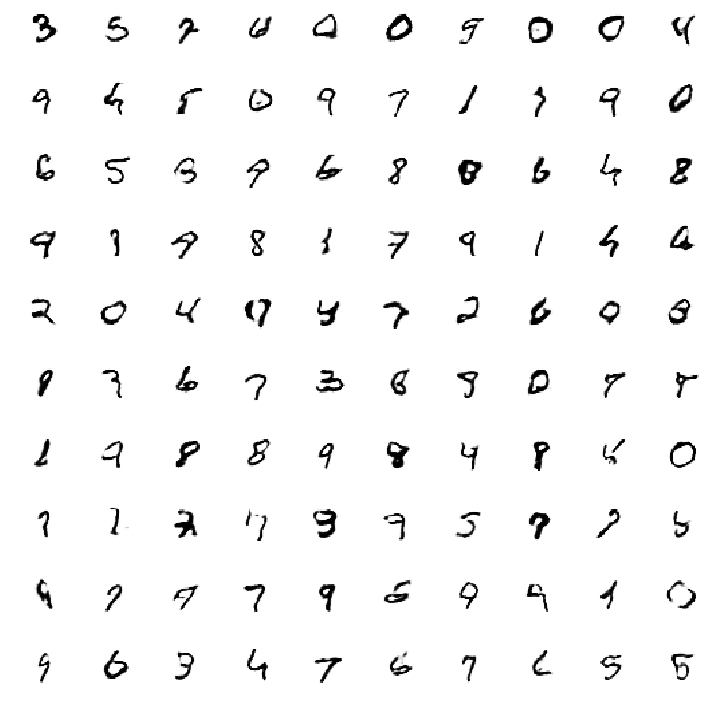

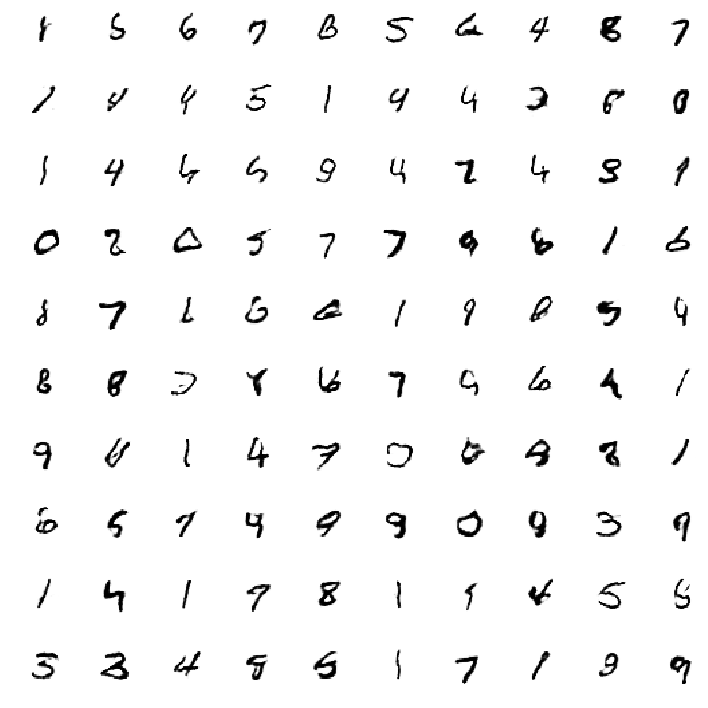

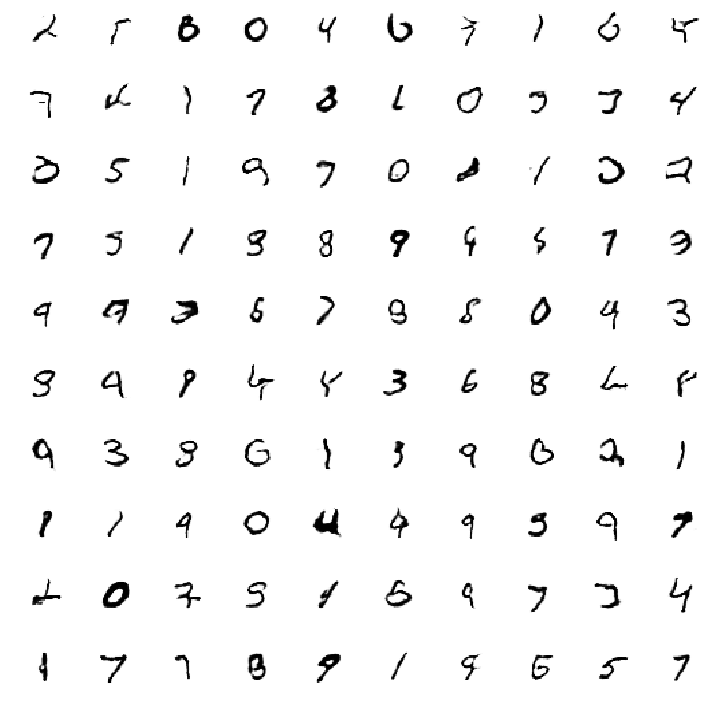

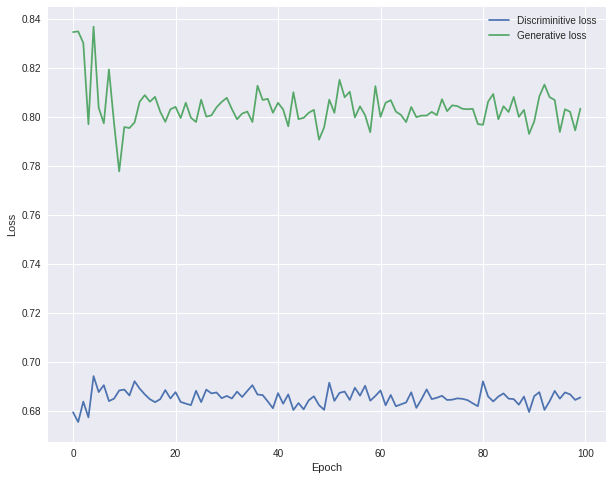

In [9]:
# Liste des Coûts du Discriminateur (un par epoch)
dLosses = []

# Liste des Coûts du Discriminateur (un par epoch)
gLosses = []

def train(epochs=1, batchSize=128):
  
    batchCount = X_train.shape[0] / batchSize
    
    # Affichage des paramètres de train
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    # ENTRAINEMENT
    
    # Pour chaque epoch
    for e in xrange(1, epochs+1):
      
        # Affichage du numéro de l'epoch
        print '-'*15, 'Epoch %d' % e, '-'*15
        
        # Pour chaque batch
        for _ in tqdm(xrange(batchCount)):
            # On génère des données random de la bonne taille pour générer <batchSize> fausses images 
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # On génère des fausses images à partir du bruit généré
            generatedImages = generator.predict(noise)
            imageBatch = imageBatch.reshape((128, 1, 28, 28))
            #print imageBatch.shape
            #print generatedImages.shape
            X = np.concatenate([imageBatch, generatedImages])

            # J'ai pas trop compris ça, j'admets
            yDis = np.zeros(2*batchSize)
            yDis[:batchSize] = 0.9

            # Entrainement du Discriminateur
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Entrainement du Générateur, le Discriminateur étant immuable
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Enregistrement des Coûts pour cette epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        # On enregistre les données relatives à l'entrainement régulièrement
        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Affichage des coûts en fonction de l'epoch
    plotLoss(e)
    
iterations = 100
batchSize = 128

# C'est parti !
train(iterations, batchSize)

# Téléchargements

In [0]:
from google.colab import files

for e in xrange(1, 100+1):
    if e == 1 or e % 20 == 0:
        files.download('gan_generated_image_epoch_%d.png' % e)
        files.download('gan_generator_epoch_%d.h5' % e)
        files.download('gan_discriminator_epoch_%d.h5' % e)